# Training an RNN for Time Series Predictions

We can use an RNN, just like a CNN, to make predictions on the MNIST dataset. The only difference being that we will input the image flattened and unrolled into the RNN; we will treat each 28 x 28 pixels image as 28 rows or 28 pixels each. 

### Add diagram of the network we intend to create

## Feature Engineering

### Loading the Data

In [1]:
%%bash 
ls -la crypto_data/

total 49752
drwxr-xr-x@  6 rajatrasal  staff      204 20 Nov 02:52 .
drwxr-xr-x  13 rajatrasal  staff      442 21 Nov 04:10 ..
-rwxr-xr-x@  1 rajatrasal  staff  5925778 27 Aug 11:23 BCH-USD.csv
-rwxr-xr-x@  1 rajatrasal  staff  6658291 25 Aug 12:42 BTC-USD.csv
-rwxr-xr-x@  1 rajatrasal  staff  6657679 25 Aug 12:42 ETH-USD.csv
-rwxr-xr-x@  1 rajatrasal  staff  6223190 25 Aug 12:42 LTC-USD.csv


From this we can see that all the data for each type of crypto-currency is in different files. We want to somehow put this together into one usable file for easy access.

In [2]:
import pandas as pd

col_names = ["time", "low", "high", "open", "close", "volume"]
df = pd.read_csv("./crypto_data/LTC-USD.csv", names=col_names)
df.head()

,time,low,high,open,close,volume
0,1528968660,96.580002,96.589996,96.589996,96.580002,9.647200
1,1528968720,96.449997,96.669998,96.589996,96.660004,314.387024
2,1528968780,96.470001,96.570000,96.570000,96.570000,77.129799
3,1528968840,96.449997,96.570000,96.570000,96.500000,7.216067
4,1528968900,96.279999,96.540001,96.500000,96.389999,524.539978


### Visualising Existing Data

Now we import all the data we want into one dataframe. This will make it easier to access later. We also change the column names style to make them easier to reference. 

In [3]:
from os import listdir

datapath = "./crypto_data/"
datafiles = listdir(datapath)

ratios = []

main_df = pd.DataFrame()

for file in datafiles:
    full_file = f"{datapath}{file}"
    ratio = file[:-4].lower().replace("-", "_")
    ratios.append(ratio)
    
    df = pd.read_csv(full_file, names=col_names)
    df.set_index("time", inplace=True)
    df = df[["close", "volume"]]
    df.rename(columns={"close": f"{ratio}_close", "volume": f"{ratio}_volume"}, inplace=True)
    print(f"{ratio} dataframe size:{df.shape}")
    
    if len(main_df) == 0:
        main_df = df
    else:
        main_df = main_df.join(df)
    
print(f"\nMain dataframe size:{main_df.shape}")
main_df.head()

bch_usd dataframe size:(92225, 2)
btc_usd dataframe size:(97724, 2)
eth_usd dataframe size:(102831, 2)
ltc_usd dataframe size:(101883, 2)

Main dataframe size:(92225, 8)


,bch_usd_close,bch_usd_volume,btc_usd_close,btc_usd_volume,eth_usd_close,eth_usd_volume,ltc_usd_close,ltc_usd_volume
time,,,,,,,,
1528968660,871.719971,5.675361,6489.549805,0.587100,NaN,NaN,96.580002,9.647200
1528968720,870.859985,26.856577,6487.379883,7.706374,486.01001,26.019083,96.660004,314.387024
1528968780,870.099976,1.124300,6479.410156,3.088252,486.00000,8.449400,96.570000,77.129799
1528968840,870.789978,1.749862,6479.410156,1.404100,485.75000,26.994646,96.500000,7.216067
1528968900,870.000000,1.680500,6479.979980,0.753000,486.00000,77.355759,96.389999,524.539978


Text(0.5,1,'Time Series Graph for Cryptocurrencies')

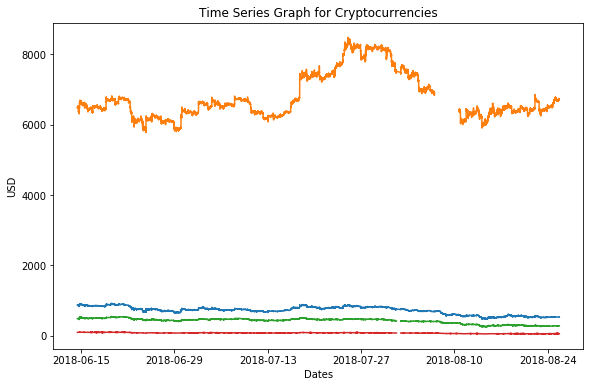

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [9.5, 6]
dates = main_df.index.map(lambda x : datetime.fromtimestamp(x))
closes = [col for col in main_df.columns.values if col[-5:] == "close"]
for df in [main_df[col] for col in closes]:
    plt.plot(dates, df)
plt.xlabel("Dates")
plt.ylabel("USD")
plt.title("Time Series Graph for Cryptocurrencies")

### Making Targets

Finally, we can take each close datapoint for each cryptocurrency and map it to the value it will have a few datapoints in the future. Thus creating a rudimental targets column.

In [5]:
import numpy as np

close_cols = [ratio for ratio in ratios]
ratio_to_predict = close_cols[0]
r = f"{ratio_to_predict}_future"
main_df[r] = main_df[f"{ratio_to_predict}_close"].shift(-3)
main_df.head()

,bch_usd_close,bch_usd_volume,btc_usd_close,btc_usd_volume,eth_usd_close,eth_usd_volume,ltc_usd_close,ltc_usd_volume,bch_usd_future
time,,,,,,,,,
1528968660,871.719971,5.675361,6489.549805,0.587100,NaN,NaN,96.580002,9.647200,870.789978
1528968720,870.859985,26.856577,6487.379883,7.706374,486.01001,26.019083,96.660004,314.387024,870.000000
1528968780,870.099976,1.124300,6479.410156,3.088252,486.00000,8.449400,96.570000,77.129799,869.989990
1528968840,870.789978,1.749862,6479.410156,1.404100,485.75000,26.994646,96.500000,7.216067,869.450012
1528968900,870.000000,1.680500,6479.979980,0.753000,486.00000,77.355759,96.389999,524.539978,869.989990


We are going to use a 1 or 0 to indicate whether the current is greater than the future or not. This is done using the `classify` function.

In [6]:
classify = lambda current, future : int(float(current) > float(future))

In [7]:
t = f"{ratio_to_predict}_target"
main_df[t] = list(map(classify, main_df[f"{ratio_to_predict}_close"], main_df[r]))
main_df[[f"{ratio_to_predict}_close", r, t]].head(10)

,bch_usd_close,bch_usd_future,bch_usd_target
time,,,
1528968660,871.719971,870.789978,1
1528968720,870.859985,870.000000,1
1528968780,870.099976,869.989990,1
1528968840,870.789978,869.450012,1
1528968900,870.000000,869.989990,1
1528968960,869.989990,870.000000,0
1528969020,869.450012,870.320007,0
1528969080,869.989990,870.650024,0
1528969140,870.000000,871.219971,0


An out of sample testing set needs to be selected. This will be the final 5% of the data.

In [8]:
from datetime import datetime

times = sorted(main_df.index.values)
last_5pc = times[-int(len(times) * 0.05):]

print(times[0] < last_5pc[0])
print(datetime.fromtimestamp(times[0]), datetime.fromtimestamp(last_5pc[0]))

True
2018-06-14 10:31:00 2018-08-21 20:32:00


Based on the testing row indices, a training/test split can be made from the initial dataframe.

In [9]:
train = main_df.drop(last_5pc)
test = main_df.loc[main_df.index.isin(last_5pc), :]

print(train.shape)
print(test.shape)

(87614, 10)
(4611, 10)


We now need to split out training and test set into features (X) and labels (y).

In [43]:
from sklearn import preprocessing
from collections import deque
import random

SEQ_LEN = 60

def train_test_split(stocks_df):
    
    for col in stocks_df.columns: 
        if "target" not in col:
            # We want to normalise the data so that each close and volume 
            # values are within the same order or magnitude.
            stocks_df[col] = stocks_df[col].pct_change()
            stocks_df.dropna(inplace=True)
            stocks_df[col] = preprocessing.scale(stocks_df[col].values)
            
    stocks_df.dropna(inplace=True)
    
    sequential_data = []
    seq_len_chunk = deque(maxlen=SEQ_LEN)
    
    for i, row in enumerate(stocks_df.values):
        seq_len_chunk.append(row[:-1])
        if i != 0 and i % SEQ_LEN == 0:
            sequential_data.append([np.array(seq_len_chunk), row[-1]])
            
    random.shuffle(sequential_data)
    
    sequential_data = np.array(sequential_data)
    
    X = sequential_data[:, 0]
    y = sequential_data[:, 1].flatten()
    
    return (X, y)

In [44]:
X_train, y_train = train_test_split(train)
X_test, y_test = train_test_split(test)

/Users/rajatrasal/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rajatrasal/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rajatrasal/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-cop

## Training the Model